<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Task 1: Project Overview and Import Libraries

In [8]:
!pip install plot_utils

     |████████████████████████████████| 13.3MB 234kB/s 


In [11]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


## Task 2: Load and Preprocess the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4423680/4422102 [==============================] - 0s 0us/step


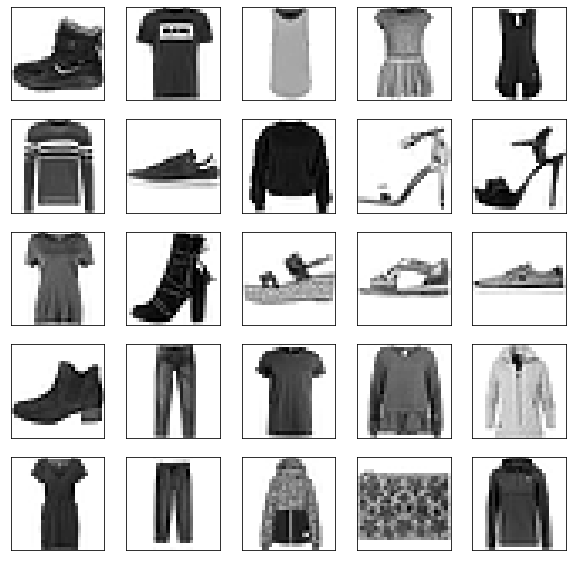

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## Task 3: Create Batches of Training Data

In [5]:
batch_size = 32
# This dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
#Combines consecutive elements of this dataset into batches.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) # drop_remainder = True because it will drop the last batch excess image so we get constant batch size of 32
#Creates a Dataset that prefetches elements from this dataset

## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

In [6]:
num_features = 100  # this is the random Gaussian noise, based on ur compute capacity increase it.

generator = keras.models.Sequential([  # note that we are using square brackets to pass and add in the sequential layers easily
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]), # input for the seq is the noise,  we can choose any dim instead of 7*7*128
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"), # upsample an image with the give seed (random noise)
    #upsample several size till we get the desired input size of 28*28*1
    # note: above in conv2dtranspose, we set the filters as (64, (5,5)-> since we loaded batches of 5 cross 5, (2,2)-> strides of 2x2 )
    keras.layers.BatchNormalization(), # alwawys us this! especially after a "selu" activation -> it is very good for dcgan
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

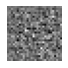

In [13]:
noise = tf.random.normal(shape=[1, num_features]) # just to test what the generator has learned, we are passing a gaussian noise to the generator
generated_images = generator(noise, training=False)
show(generated_images, 1)

## Tak 5: Build the Discriminator Network for DCGAN

In [14]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]), # set the same (64.....) also note that input_shape is shape of the fashion_mnist dataset which is 28*28*1
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"), # just double it
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid') # last layer always use sigmoid
])

In [15]:
decision = discriminator(generated_images) # the discriminator will op values btw (0 to 1) this is a bialry classification
# thus 0 -> fake 1-> real image from the test set
print(decision)

tf.Tensor([[0.49930608]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [16]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # always set to false
gan = keras.models.Sequential([generator, discriminator]) # join both the discriminator and generator
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Task 7: Define Training Procedure

In [17]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100]) # hereshape is batch_size and 100 is the num_features(noise, we have defined it in TASK4)

In [18]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset: # xbatch is the images from training test                  # train the generator to create a mini batch of fake images
            noise = tf.random.normal(shape=[batch_size, num_features]) # as usual create a vector for random noise note the shape is [batch_size, 100]
            generated_images = generator(noise) # train the generator on the random noise
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # create a dataset of both real and fake images so that later the discrimnaror can classify as real or fake
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # this step creates the labelling of vectors, here  [[0.]] means fake
            discriminator.trainable = True # note now set it to true to train
            discriminator.train_on_batch(X_fake_and_real, y1) # pass the combined dataset and the labels
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size) # use only real labels, here we want the generator to be able to fool the discriminator
            discriminator.trainable = False # now again set as false
            gan.train_on_batch(noise, y2) # pass only real variables and noise
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed) # to create a gif, also note the epoch + 1 since by default python uses o, we need to start from 1st epoch
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed) #for each epoch

# Overall process

we are going to train the discriminator a bit and the n train the generator

for x steps of training we start by sampling a mini batch of gaussian noise and also sample a mini batch of real images

pass noise to the genereator and get the fake images out.

so nw we will have a mini batch of fake images and a mini batch of real images

pick a gradient step on discriminator using the mini batch of real_and_fake and update the descriminator parameters. we do this a couple of times. this trains the descriminator

step2: to train the generator, we take a mini batch of real images and train the generator (1st line of 2nd for loop) pass the noise to the generator "gan"

now backprop on this to make the generator better

Our aim is to make the generator fool the discriminator as much as possible

thus we repeat the steps, here the seed we defined above is used to tell us how good the job is done



In [19]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Task 8: Train DCGAN

In [20]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.   # to make it perform better we need to reshape the x_train , here -1 is used to scale

In [21]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

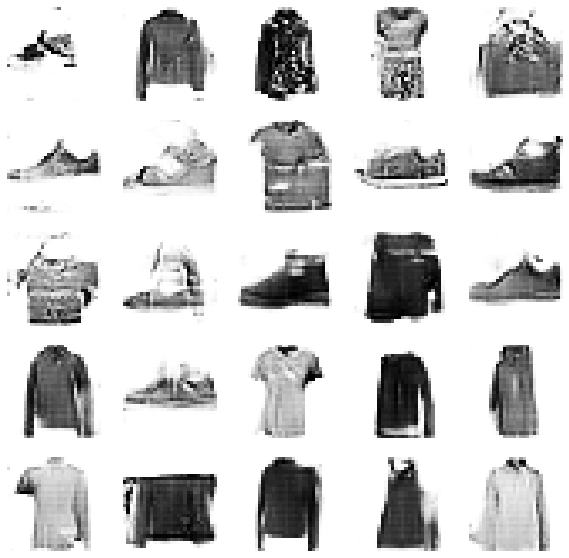

CPU times: user 8min 8s, sys: 35.6 s, total: 8min 44s
Wall time: 11min 51s


In [22]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## Task 9: Generate Synthetic Images with DCGAN

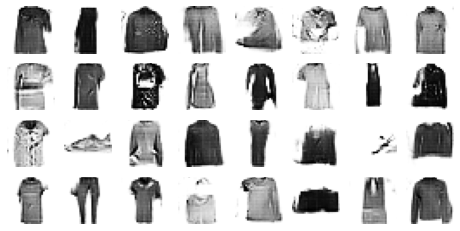

In [23]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

In [24]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
display.Image(filename=anim_file)

ValueError: ignored